# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import os

from addict import Dict
import json

from datetime import timedelta, datetime

In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

import hplc_data_processing as hplc

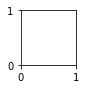

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Helper plotting functions

In [6]:
def no_sec(df):
    fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')
    ln1, = ax.plot(df.uv_280_ml, df.uv_280_mAU)

    ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]')
    ln2, = ax2.plot(df.Cond_ml, df.Cond_mS_cm, linestyle='--', color='black')

    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.2))
    ax3.set_ylabel('pH')
    ln3, = ax3.plot(df.pH_ml, df.pH_pH, linestyle=':', color='magenta')

    ax.yaxis.label.set_color(ln1.get_color())
    ax2.yaxis.label.set_color(ln2.get_color())
    ax3.yaxis.label.set_color(ln3.get_color())
    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=ln1.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=ln2.get_color(), **tkw)
    ax3.tick_params(axis='y', colors=ln3.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)
    return fig, ax, ax2, ax3

def with_sec(df, df_norm, norm_vol=None, fig=None, ax=None, show_twinx=True, ax3_position=1.2):
    if fig is None and ax is None:
        fig, ax = my_plot.instantiate_fig(x=9, y=8, xlabel='Volume [ml]', ylabel='Normalized conc.')

    ln_1 = ax.plot(df_norm.volume_midpoint_ml, df_norm.large_280, 'o-', label='Large agg.')
    ln_2 = ax.plot(df_norm.volume_midpoint_ml, df_norm.small_280, 'o-', label='Small agg.')
    ln_3 = ax.plot(df_norm.volume_midpoint_ml, df_norm.mab_254, 'o-', label='mAb')
    ln_4 = ax.plot(df_norm.volume_midpoint_ml, df_norm.lmw1_280, 'o-', label='LMW 1')
    if norm_vol is not None:
        uv_295_norm = df.iloc[(df['uv_295_ml']-norm_vol).abs().argsort()].iloc[0]['uv_295_mAU']
    else:
        uv_295_norm = df.uv_295_mAU.max()
    ln_7 = ax.plot(df.uv_295_ml, df.uv_295_mAU/uv_295_norm, 'k', label='A295')

    if show_twinx:
        ax2 = my_plot.get_twinx(ax, ylabel='Conductivity [mS/cm]')
        ln_8 = ax2.plot(df.Cond_ml, df.Cond_mS_cm, 'k--', label='Cond.')

        ax3 = ax.twinx()
        ax3.spines["right"].set_position(("axes", ax3_position))
        ax3.set_ylabel('pH')
        ln9 = ax3.plot(df.pH_ml, df.pH_pH, linestyle=':', color='magenta', label='pH')
        ax3.yaxis.label.set_color('magenta')
        tkw = dict(size=6, width=1.5)
        ax3.tick_params(axis='y', colors='magenta', **tkw)
    else:
        ax2 = my_plot.get_twinx(ax)
        ln_8 = ax2.plot(df.Cond_ml, df.Cond_mS_cm, 'k--', label='Cond.')

        ax3 = ax.twinx()
        ln9 = ax3.plot(df.pH_ml, df.pH_pH, linestyle=':', color='magenta', label='pH')
        
    lns = ln_1 + ln_2 + ln_3 + ln_4 + ln_7 + ln_8 + ln9
    labs = [l.get_label() for l in lns]
    return fig, ax, ax2, ax3, lns, labs

def cip(df_cip):
    fig, ax = my_plot.instantiate_fig(x=7, y=6, ylabel='Normalized conc.')
    ticks = ax.set_xticks(df_cip.index, df_cip.name, rotation=30, ha='right', rotation_mode='anchor')
    rects_1 = ax.bar(df_cip.index, df_cip.norm_conc, width=0.75)
    my_plot.set_layout(fig, ax)
    return fig, ax

def sec_chromatograms(data, sample_ids, zoomed=False, lines=True, group='pafvin', index=3, fig=None, ax=None, xaxis='time'):
    if fig is None and ax is None:
        if xaxis == 'time':
            fig, ax = my_plot.instantiate_fig(xlabel='Time [min]', ylabel='A280 [AU]')
        elif xaxis == 'volume':
            fig, ax = my_plot.instantiate_fig(xlabel='Volume [ml]', ylabel='A280 [AU]')
            
    if group == 'pafvin':
        sample_subset_ids = [s for s in sample_ids if 'PAFVIN' in s]
    elif group == 'eluate':
        sample_subset_ids = [s for s in sample_ids if s[index]=='2']
    elif group == 'cip':
        sample_subset_ids = [s for s in sample_ids if 'CIP' in s]
    elif group == 'ft':
        sample_subset_ids = [s for s in sample_ids if s[index]=='1']
    
    for s in sample_subset_ids:
        if xaxis == 'time':
            ax.plot(data[s].df.time_min, data[s].df.uv_280)
            if lines:
                for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45]:
                    ax.axvline(t, linestyle='--', color='black')
            if zoomed:
                ax.set_ylim(-0.005, 0.1)
                ax.set_xlim(8.5, 18.5)
        elif xaxis == 'volume':
            ax.plot(data[s].df.time_min * 0.6, data[s].df.uv_280)
            if lines:
                for t in [8.7, 10.517, 11.77, 12.25, 15.55, 15.76, 17.84, 21.45]:
                    ax.axvline(t * 0.6, linestyle='--', color='black')
            if zoomed:
                ax.set_ylim(-0.005, 0.1)
                ax.set_xlim(8.5 * 0.6, 18.5 * 0.6)
        
    my_plot.set_layout(fig, ax)
    return fig, ax

# Load data

In [7]:
df_x_150, data_x_150, sample_ids_x_150, df_areas_x_150, df_norm_all_x_150, df_norm_x_150, df_cip_x_150, feed_areas_x_150 =\
hplc.get_data('./Akta_data/2022-08-18_AEX_FT_poros_xq.csv', './hplc_data/2022-08-19_AEX_FT_XQ/')

df_c_150, data_c_150, sample_ids_c_150, df_areas_c_150, df_norm_all_c_150, df_norm_c_150, df_cip_c_150, feed_areas_c_150 =\
hplc.get_data('./Akta_data/2022-08-19_AEX_FT_capto_q.csv', './hplc_data/2022-08-21_AEX_FT_CQ/')

df_h_150, data_h_150, sample_ids_h_150, df_areas_h_150, df_norm_all_h_150, df_norm_h_150, df_cip_h_150, feed_areas_h_150 =\
hplc.get_data('./Akta_data/2022-08-21_AEX_FT_poros_50_hq.csv', './hplc_data/2022-08-23_AEX_FT_HQ/')

/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df_x_30, data_x_30, sample_ids_x_30, df_areas_x_30, df_norm_all_x_30, df_norm_x_30, feed_areas_x_30 =\
hplc.get_data('./Akta_data/2022-08-23_AEX_only_FT_poros_xq_30_cm_h_2.csv', './hplc_data/2022-08-25_AEX_FT_XQ_30/', cip=False, start_index=6)

df_c_30, data_c_30, sample_ids_c_30, df_areas_c_30, df_norm_all_c_30, df_norm_c_30, feed_areas_c_30 =\
hplc.get_data('./Akta_data/2022-08-24_AEX_only_FT_CQ_30_cm_h.csv', './hplc_data/2022-08-26_AEX_FT_CQ_30/', cip=False, start_index=6)

df_h_30, data_h_30, sample_ids_h_30, df_areas_h_30, df_norm_all_h_30, df_norm_h_30, feed_areas_h_30 =\
hplc.get_data('./Akta_data/2022-08-26_AEX_only_FT_poros_50_hq_30_cm_h.csv', './hplc_data/2022-08-27_AEX_FT_HQ_30/', cip=False, start_index=6)

/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/chase/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Multi-panel plots

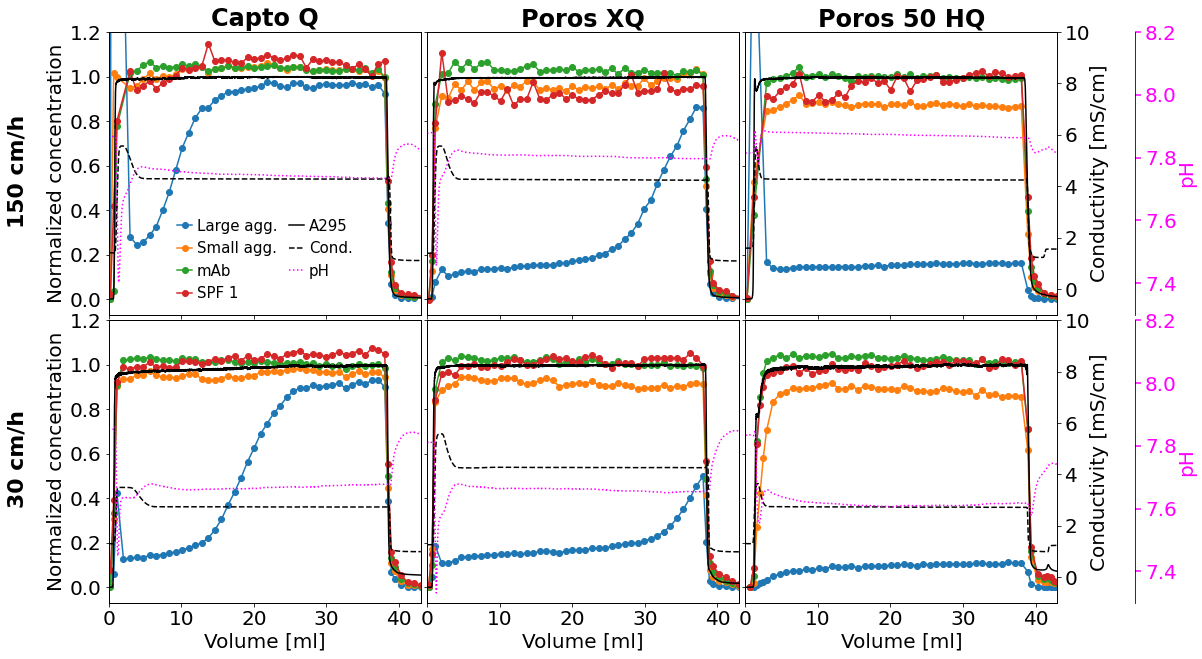

In [9]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches(17, 10.5, forward=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_150, df_norm_c_150, fig=fig, ax=ax[0, 0], show_twinx=False)

ax[0, 0].set_xlim(0, 43)
ax[0, 0].set_ylim(-0.07, 1.2)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_30, df_norm_c_30, fig=fig, ax=ax[1, 0], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_150, df_norm_x_150, fig=fig, ax=ax[0, 1], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_30, df_norm_x_30, norm_vol=35, fig=fig, ax=ax[1, 1], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_150, df_norm_h_150, fig=fig, ax=ax[0, 2], show_twinx=True, ax3_position=1.25)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_30, df_norm_h_30, norm_vol=35, fig=fig, ax=ax[1, 2], show_twinx=True, ax3_position=1.25)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)

legend = ax[0, 0].legend(lns, labs, frameon=False, handlelength=1, ncol=2, fontsize=15, columnspacing=0.8, handletextpad=0.3)

t = ax[0, 0].set_title('Capto Q', weight='bold')
t = ax[0, 1].set_title('Poros XQ', weight='bold')
t = ax[0, 2].set_title('Poros 50 HQ', weight='bold')
xlabel = ax[1, 0].set_xlabel('Volume [ml]')
xlabel = ax[1, 1].set_xlabel('Volume [ml]')
xlabel = ax[1, 2].set_xlabel('Volume [ml]')

ylabel = ax[0, 0].set_ylabel('Normalized concentration')
ylabel = ax[1, 0].set_ylabel('Normalized concentration')
t = ax[0, 0].annotate('150 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)
t = ax[1, 0].annotate('30 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)

# plt.savefig(f'./images/9_all_FT_profiles.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/9_all_FT_profiles.tif', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/9_all_FT_profiles.pdf', bbox_inches='tight')

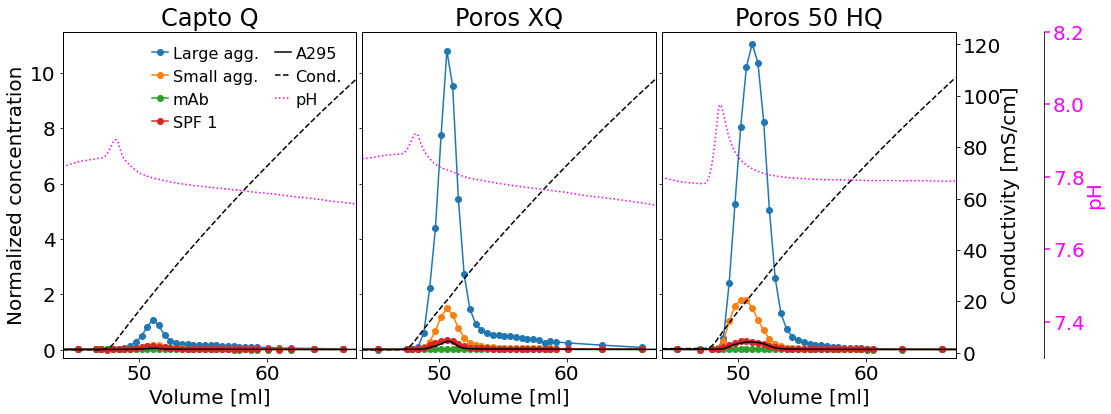

In [10]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(16, 6, forward=True)
plt.subplots_adjust(wspace=0.02)

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_150, df_norm_c_150, fig=fig, ax=ax[0], show_twinx=False)
ax[0].set_xlim(44, 67)
ax[0].set_ylim(-0.3, 11.5)
ax2.set_ylim(-2, 125)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_150, df_norm_x_150, fig=fig, ax=ax[1], show_twinx=False)
ax2.set_ylim(-2, 125)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_150, df_norm_h_150, fig=fig, ax=ax[2], ax3_position=1.3)
ax2.set_ylim(-2, 125)
ax3.set_ylim(7.3, 8.2)

legend = ax[0].legend(lns, labs, frameon=False, handlelength=1, ncol=2, fontsize=16, columnspacing=1, handletextpad=0.3)

t = ax[0].set_title('Capto Q')
t = ax[1].set_title('Poros XQ')
t = ax[2].set_title('Poros 50 HQ')
xlabel = ax[0].set_xlabel('Volume [ml]')
xlabel = ax[1].set_xlabel('Volume [ml]')
xlabel = ax[2].set_xlabel('Volume [ml]')

ylabel = ax[0].set_ylabel('Normalized concentration')

# plt.savefig(f'./images/9_all_eluate_profiles_150_cm_h.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/9_all_eluate_profiles_150_cm_h.pdf', bbox_inches='tight')

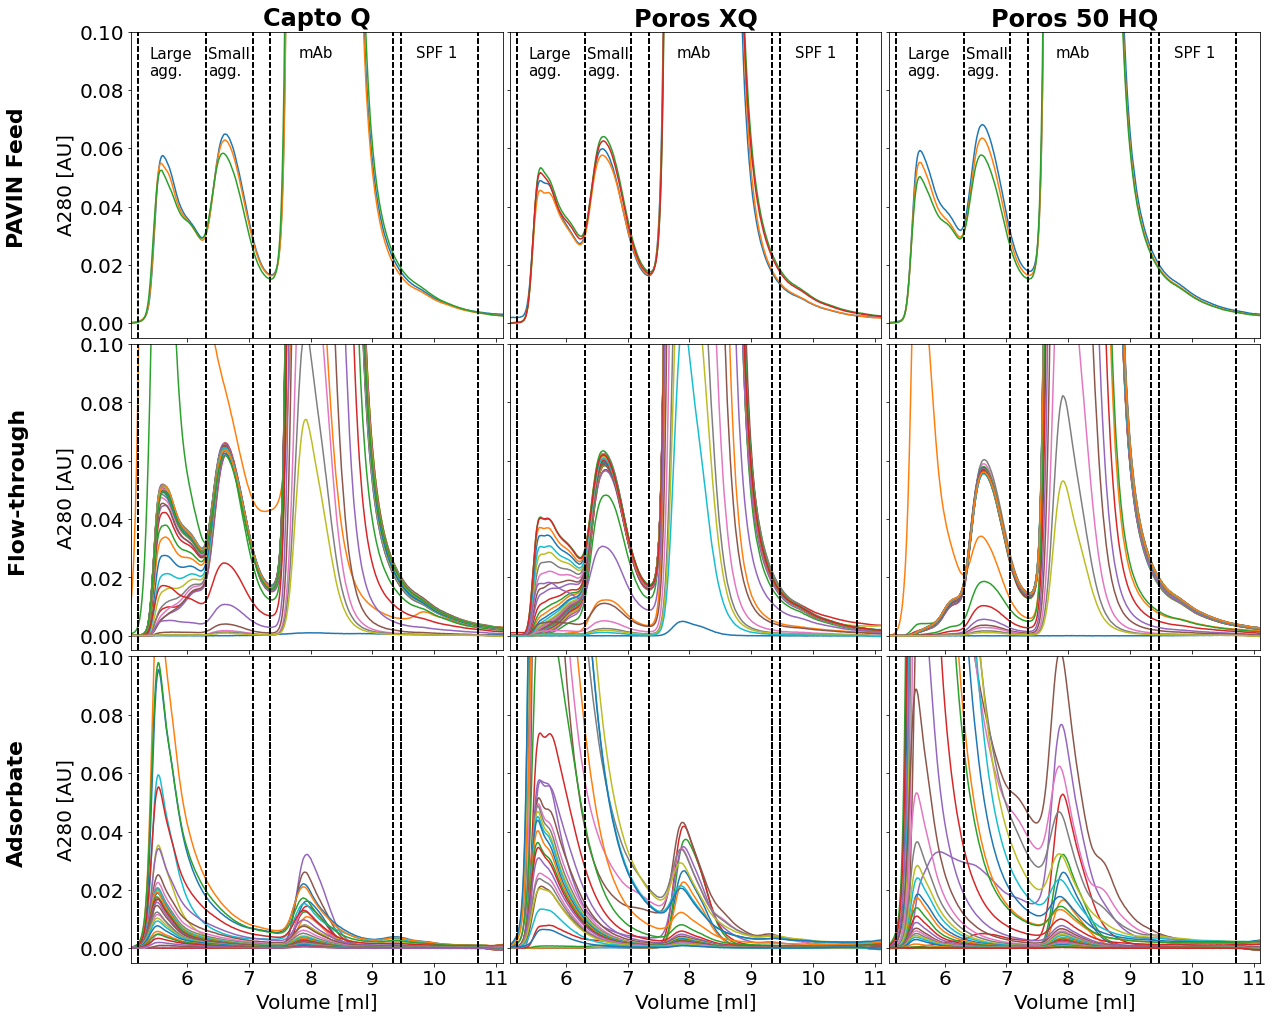

In [11]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches(17, 14, forward=True)

for i, data, sample_ids in zip([0, 1, 2], [data_c_150, data_x_150, data_h_150], [sample_ids_c_150, sample_ids_x_150, sample_ids_h_150]):
    f, a = sec_chromatograms(data, sample_ids, zoomed=True, lines=True, group='pafvin', xaxis='volume', fig=fig, ax=ax[0, i])
    f, a = sec_chromatograms(data, sample_ids, zoomed=True, lines=True, group='ft', xaxis='volume', fig=fig, ax=ax[1, i])
    f, a = sec_chromatograms(data, sample_ids, zoomed=True, lines=True, group='eluate', xaxis='volume', fig=fig, ax=ax[2, i])

plt.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(3):
    xlabel = ax[2, i].set_xlabel('Volume [ml]')
    ylabel = ax[i, 0].set_ylabel('A280 [AU]')
    t = ax[0, i].annotate('Large\nagg.', xytext=(5.4, 0.085), xy=(6, 0.05), fontsize=15)
    t = ax[0, i].annotate('Small\nagg.', xytext=(6.35, 0.085), xy=(6, 0.05), fontsize=15)
    t = ax[0, i].annotate('mAb', xytext=(7.8, 0.091), xy=(6, 0.05), fontsize=15)
    t = ax[0, i].annotate('SPF 1', xytext=(9.7, 0.091), xy=(6, 0.05), fontsize=15)

t = ax[0, 0].set_title('Capto Q', weight='bold')
t = ax[0, 1].set_title('Poros XQ', weight='bold')
t = ax[0, 2].set_title('Poros 50 HQ', weight='bold')

t = ax[0, 0].annotate('PAVIN Feed', xytext=(3.1, 0.05), xy=(6, 0.05), rotation=90, weight='bold', fontsize=22, va='center')
t = ax[1, 0].annotate('Flow-through', xytext=(3.1, 0.05), xy=(6, 0.05), rotation=90, weight='bold', fontsize=22, va='center')
t = ax[2, 0].annotate('Adsorbate', xytext=(3.1, 0.05), xy=(6, 0.05), rotation=90, weight='bold', fontsize=22, va='center')

# plt.savefig(f'./images/9_multi_panel_SEC_profiles_150_cm_h.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'./images/9_multi_panel_SEC_profiles_150_cm_h.pdf', bbox_inches='tight')

# Mass balances

Loaded to 37.83 ml

In [12]:
for df in [df_norm_c_150, df_norm_x_150, df_norm_h_150]:
    for i, cont in df.iterrows():
        if i == 0:
            prev_vol = cont.volume_midpoint_ml - 0.9
            next_vol = df.at[i+1, 'volume_midpoint_ml']
        elif i == len(df) - 1:
            prev_vol = df.at[i-1, 'volume_midpoint_ml']
            next_vol = cont.volume_midpoint_ml + 0.9
        else:
            prev_vol = df.at[i-1, 'volume_midpoint_ml']
            next_vol = df.at[i+1, 'volume_midpoint_ml']
        cur_vol = cont.volume_midpoint_ml
        start_vol = (cur_vol - prev_vol)/2 + prev_vol
        end_vol = (next_vol - cur_vol)/2 + cur_vol
        sample_vol = end_vol - start_vol
        df.at[i, 'sample_vol'] = sample_vol

In [13]:
# true_val = 37.83
# for df in [df_norm_c_150, df_norm_x_150, df_norm_h_150]:
#     val = np.sum(df.large_280 * df.sample_vol)
#     print((val - true_val)/true_val * 100, val)

In [14]:
true_val = 37.83

desc_data = {}
for component in ['large_280', 'small_280', 'mab_254', 'lmw1_280']:
    temp = []
    for df in [df_norm_c_150, df_norm_x_150, df_norm_h_150]:
        acc, elu = 0, 0
        for i, cont in df.iterrows():
            if cont.volume_midpoint_ml < 37.83:
                val = (1.0 - cont[component]) * cont.sample_vol
#                 if val > 0:
#                     acc += val
                acc += val
            elif 37.83 <= cont.volume_midpoint_ml < 44:
                acc -= cont[component] * cont.sample_vol
            elif cont.volume_midpoint_ml >= 44:
                elu += cont[component] * cont.sample_vol
            else:
                assert False
        temp.append((acc - elu)/true_val * 100)
    desc_data[component] = temp
df_desc_data = pd.DataFrame(desc_data)
df_desc_data

,large_280,small_280,mab_254,lmw1_280
0,-12.489194,-4.705015,-2.704649,-5.664376
1,6.583564,-5.153916,-2.933377,3.990757
2,-2.602554,0.034634,1.043082,0.793381


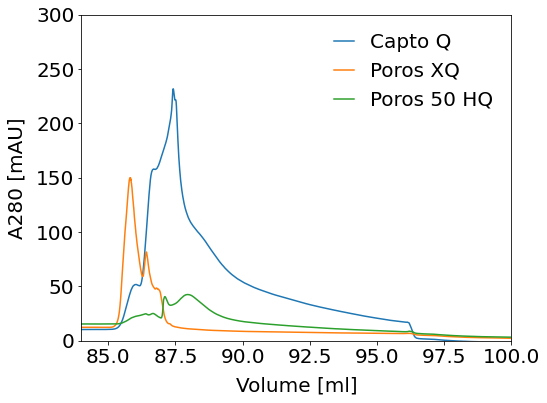

In [15]:
fig, ax = my_plot.instantiate_fig(x=8, y=6, xlabel='Volume [ml]', ylabel='A280 [mAU]')

for df, label in zip([df_c_150, df_x_150, df_h_150], ['Capto Q', 'Poros XQ', 'Poros 50 HQ']):
    ln1, = ax.plot(df.uv_280_ml, df.uv_280_mAU, label=label)

ax.set_xlim(84, 100)
ax.set_ylim(0, 300)
my_plot.set_layout(fig, ax, legend=True)

# ELISA results

In [16]:
large_agg_cont = []
for df in [df_norm_c_150, df_norm_x_150, df_norm_h_150, df_norm_c_30, df_norm_x_30, df_norm_h_30]:
    large_agg_cont.append(df[df.frac.str.contains('G11')]['large_280'].iloc[0])
large_agg_cont_150 = large_agg_cont[:3]
large_agg_cont_30 = large_agg_cont[3:]

In [17]:
labels = ['CQ 150 cm/h', 'XQ 150 cm/h', 'HQ 150 cm/h', 'CQ 30 cm/h', 'XQ 30 cm/h', 'HQ 30 cm/h']
elisa_ppm = [1.80E+03, 8.61E+02, 2.66E+01, 3.09E+02, 1.97E+02, 3.52E+00]
elisa_ppm_150 = elisa_ppm[:3]
elisa_ppm_30 = elisa_ppm[3:]

# df = pd.DataFrame({'label':labels, 'norm_large_agg':large_agg_cont, 'elisa_ppm':elisa_ppm})

resins = ['Capto Q', 'Poros XQ', 'Poros 50 HQ']
df_split = pd.DataFrame({'resin':resins, 'norm_large_agg_150':large_agg_cont_150, 'norm_large_agg_30':large_agg_cont_30, 
                         'elisa_ppm_150':elisa_ppm_150, 'elisa_ppm_30':elisa_ppm_30})

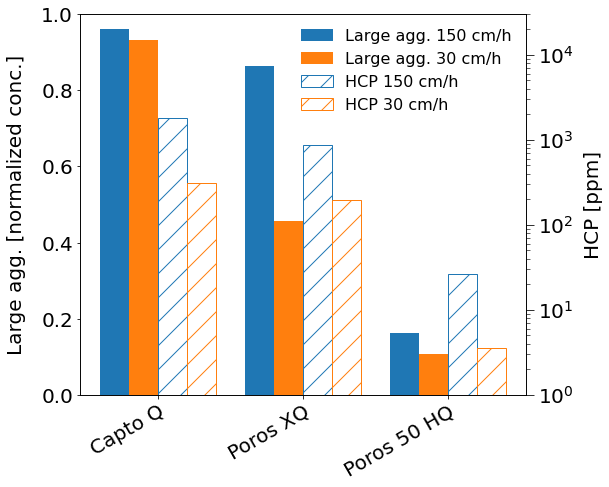

In [18]:
fig, ax = my_plot.instantiate_fig(x=8, y=7, ylabel='Large agg. [normalized conc.]', ypad=15)
ticks = ax.set_xticks(df_split.index, df_split.resin, rotation=30, ha='right', rotation_mode='anchor')
ylim = ax.set_ylim(0, 1)
rects_1 = ax.bar(df_split.index-0.3, df_split.norm_large_agg_150, width=0.2, label='Large agg. 150 cm/h')
rects_2 = ax.bar(df_split.index-0.1, df_split.norm_large_agg_30, width=0.2, label='Large agg. 30 cm/h')

ax2 = my_plot.get_twinx(ax, ylabel='HCP [ppm]', ypad=10)
ylim = ax2.set_ylim(1e0, 3e4)
ax2.set_yscale('log')
rects_3 = ax2.bar(df_split.index+0.1, df_split.elisa_ppm_150, width=0.2, color='none', edgecolor='tab:blue', label='HCP 150 cm/h', hatch='/')
rects_4 = ax2.bar(df_split.index+0.3, df_split.elisa_ppm_30, width=0.2, color='none', edgecolor='tab:orange', label='HCP 30 cm/h', hatch='/')

lns = [rects_1, rects_2, rects_3, rects_4]
labs = [rects_1.get_label(), rects_2.get_label(), rects_3.get_label(), rects_4.get_label()]
legend = ax.legend(lns, labs, frameon=False, handlelength=2, fontsize=16)

ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)

# plt.savefig('./images/9_ELISA_AEX_FT_G11.png', dpi=300, bbox_inches='tight')

# Mass fractions of aggregates in the PAFVIN feed and measurement variability

In [23]:
all_data = [data_c_150, data_x_150, data_h_150, data_c_30, data_x_30, data_h_30]
all_ids = [sample_ids_c_150, sample_ids_x_150, sample_ids_h_150, 
           sample_ids_c_30, sample_ids_x_30, sample_ids_h_30]

large_percent, small_percent = [], []
for data, sample_ids in zip(all_data, all_ids):
    sample_subset_ids = [s for s in sample_ids if 'PAFVIN' in s]
    for s in sample_subset_ids:
        large_percent.append(data[s].percentages_280['large'])
        small_percent.append(data[s].percentages_280['small'])
large_percent = np.array(large_percent)
small_percent = np.array(small_percent)

In [24]:
large_percent.mean(), small_percent.mean()

(1.4854654200939266, 1.6128069239294494)

In [25]:
np.std(large_percent, ddof=1)/large_percent.mean() * 100, np.std(small_percent, ddof=1)/small_percent.mean() * 100

(9.19316880711157, 3.3240967842416693)

# Comparison of HCP content and large aggregate content

In [26]:
large_percent_g11, small_percent_g11 = [], []
for data, sample_ids in zip(all_data, all_ids):
    sample_subset_ids = [s for s in sample_ids if 'G11' in s]
    for s in sample_subset_ids:
        large_percent_g11.append(data[s].percentages_280['large'])
        small_percent_g11.append(data[s].percentages_280['small'])
large_percent_g11 = np.array(large_percent_g11)
small_percent_g11 = np.array(small_percent_g11)

In [27]:
df = pd.DataFrame({'label':labels, 'large_agg_percent':large_percent_g11, 'small_agg_percent':small_percent_g11, 'elisa_ppm':elisa_ppm})
df['total_agg_percent'] = df.large_agg_percent + df.small_agg_percent

In [28]:
df_pr_a = pd.read_csv('./Pro_A_wash_study_mass_fracs_with_elisa.csv')
df_pr_a['total_agg_percent'] = df_pr_a.large + df_pr_a.small

In [21]:
# fig, ax = my_plot.instantiate_fig(x=7, y=6.5, ylabel='ELISA HCP content [ppm]', xlabel='Large agg. mass fraction [%]', xpad=15, ypad=15)
# ax.scatter(df_pr_a.large, df_pr_a.hcp_ppm, label='Pro A wash study\n(eluate pools)')
# ax.scatter(df.large_agg_percent, df.elisa_ppm, label='AEX FT\n(at 98% load)')
# ax.set_yscale('log')

# my_plot.set_layout(fig, ax, legend=True, frameon=True)
# ax.tick_params(which='major', length=8)
# ax.tick_params(which='minor', length=4)
# # plt.savefig('./images/9_ELISA_correlation_large.png', dpi=300, bbox_inches='tight')

In [22]:
# fig, ax = my_plot.instantiate_fig(x=7, y=6.5, ylabel='ELISA HCP content [ppm]', xlabel='Small agg. mass fraction [%]', xpad=15, ypad=15)
# ax.scatter(df_pr_a.small, df_pr_a.hcp_ppm, label='Pro A wash study\n(eluate pools)')
# ax.scatter(df.small_agg_percent, df.elisa_ppm, label='AEX FT\n(at 98% load)')
# ax.set_yscale('log')

# my_plot.set_layout(fig, ax, legend=True, frameon=True)
# plt.savefig('./images/9_ELISA_correlation_small.png', dpi=300, bbox_inches='tight')

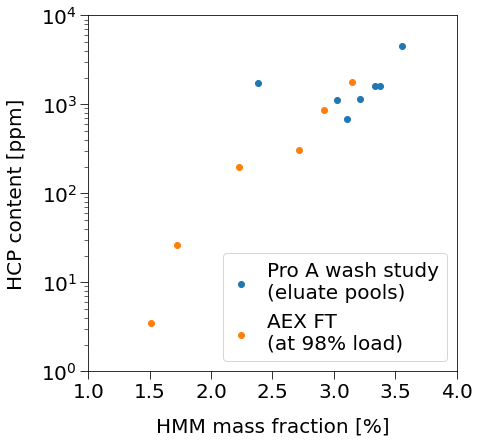

In [29]:
fig, ax = my_plot.instantiate_fig(x=7, y=6.5, ylabel='HCP content [ppm]', xlabel='HMM mass fraction [%]', xpad=15, ypad=15)
ax.scatter(df_pr_a.total_agg_percent, df_pr_a.hcp_ppm, label='Pro A wash study\n(eluate pools)')
ax.scatter(df.total_agg_percent, df.elisa_ppm, label='AEX FT\n(at 98% load)')
ax.set_yscale('log')
ax.set_ylim(1e0, 1e4)
ax.set_xlim(1, 4)

my_plot.set_layout(fig, ax, legend=True, frameon=True)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
# plt.savefig('./images/9_ELISA_correlation_total_hmw.png', dpi=300, bbox_inches='tight')

In [30]:
df_pr_a

,wash_name,nice_name,mab_area,large,small,mab,lmw1,lmw2,lmw3,monomer_loss_percent,hcp_ppm,total_agg_percent
0,blank,Blank,6.175180,1.987721,1.565904,94.525461,0.696835,0.382257,0.162426,0.000000,4570.0,3.553625
1,urea 1,1 M Urea,6.234980,1.139856,1.240184,96.116823,0.602163,0.226675,0.150670,-0.968391,1760.0,2.380040
2,tween,1% Tween 80,6.183410,1.828794,1.551027,94.917964,0.675175,0.273399,0.151075,-0.133265,1630.0,3.379821
3,IPA,10% IPA,6.092655,1.873038,1.463870,94.968979,0.641685,0.327077,0.146880,1.336402,1590.0,3.336908
4,arginine,0.45 M Arginine,5.738101,1.703246,1.507962,94.829141,0.687472,0.471820,0.149953,7.078000,1140.0,3.211208
5,NaCl,0.5 M NaCl,6.296602,1.590422,1.438621,95.295534,0.648506,0.302417,0.141470,-1.966289,1130.0,3.029043
6,10,pH 10,6.050223,1.575358,1.528316,95.376135,0.599051,0.226159,0.146145,2.023538,691.0,3.103675


In [31]:
df

,label,large_agg_percent,small_agg_percent,elisa_ppm,total_agg_percent
0,CQ 150 cm/h,1.519654,1.631404,1800.00,3.151058
1,XQ 150 cm/h,1.290565,1.628712,861.00,2.919277
2,HQ 150 cm/h,0.268251,1.453332,26.60,1.721584
3,CQ 30 cm/h,1.196092,1.516608,309.00,2.712700
4,XQ 30 cm/h,0.703215,1.525450,197.00,2.228666
5,HQ 30 cm/h,0.143298,1.368975,3.52,1.512273


In [27]:
large_agg_percent_150 = df.large_agg_percent[:3].values
large_agg_percent_30 = df.large_agg_percent[3:].values

df_split['large_agg_percent_150'] = large_agg_percent_150
df_split['large_agg_percent_30'] = large_agg_percent_30

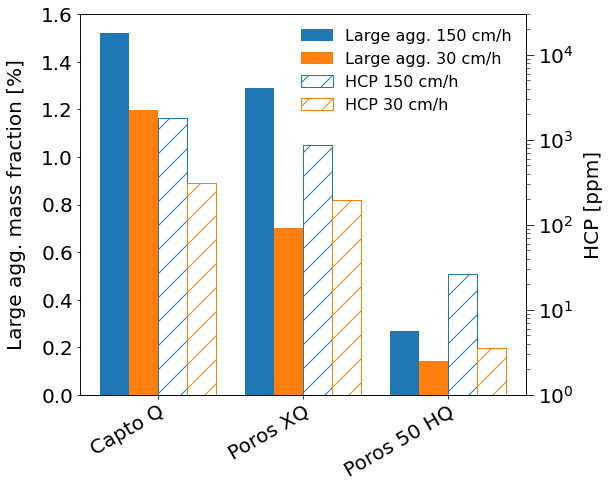

In [52]:
fig, ax = my_plot.instantiate_fig(x=8, y=7, ylabel='Large agg. mass fraction [%]', ypad=15)
ticks = ax.set_xticks(df_split.index, df_split.resin, rotation=30, ha='right', rotation_mode='anchor')
ylim = ax.set_ylim(0, 1.6)
rects_1 = ax.bar(df_split.index-0.3, df_split.large_agg_percent_150, width=0.2, label='Large agg. 150 cm/h')
rects_2 = ax.bar(df_split.index-0.1, df_split.large_agg_percent_30, width=0.2, label='Large agg. 30 cm/h')

ax2 = my_plot.get_twinx(ax, ylabel='HCP [ppm]', ypad=10)
ylim = ax2.set_ylim(1e0, 3e4)
ax2.set_yscale('log')
rects_3 = ax2.bar(df_split.index+0.1, df_split.elisa_ppm_150, width=0.2, color='none', edgecolor='tab:blue', label='HCP 150 cm/h', hatch='/')
rects_4 = ax2.bar(df_split.index+0.3, df_split.elisa_ppm_30, width=0.2, color='none', edgecolor='tab:orange', label='HCP 30 cm/h', hatch='/')

lns = [rects_1, rects_2, rects_3, rects_4]
labs = [rects_1.get_label(), rects_2.get_label(), rects_3.get_label(), rects_4.get_label()]
legend = ax.legend(lns, labs, frameon=False, handlelength=2, fontsize=16)

ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)

# plt.savefig('./images/9_ELISA_AEX_FT_G11_mass_fractions.png', dpi=300, bbox_inches='tight')

In [29]:
# df_split.to_csv('./AEX_FT_150_G11_mass_fracs_and_norm_conc_with_elisa.csv', index=False)
# df.to_csv('./AEX_FT_150_G11_mass_fracs_all_with_elisa.csv', index=False)

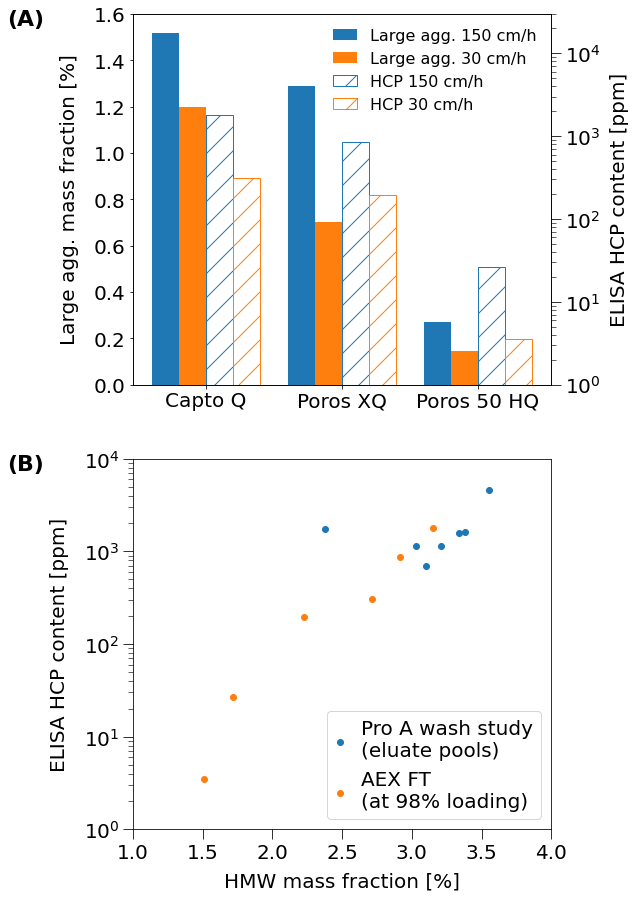

In [61]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(7.5, 15, forward=True)
# plt.subplots_adjust(wspace=0.02, hspace=0.02)

# ax[0]
ax[0].set_ylabel('Large agg. mass fraction [%]', labelpad=15)
ticks = ax[0].set_xticks(df_split.index, df_split.resin, rotation=0, ha='center', rotation_mode='anchor')
ylim = ax[0].set_ylim(0, 1.6)
rects_1 = ax[0].bar(df_split.index-0.3, df_split.large_agg_percent_150, width=0.2, label='Large agg. 150 cm/h')
rects_2 = ax[0].bar(df_split.index-0.1, df_split.large_agg_percent_30, width=0.2, label='Large agg. 30 cm/h')

ax2 = my_plot.get_twinx(ax[0], ylabel='ELISA HCP content [ppm]', ypad=10)
ylim = ax2.set_ylim(1e0, 3e4)
ax2.set_yscale('log')
rects_3 = ax2.bar(df_split.index+0.1, df_split.elisa_ppm_150, width=0.2, color='none', edgecolor='tab:blue', label='HCP 150 cm/h', hatch='/')
rects_4 = ax2.bar(df_split.index+0.3, df_split.elisa_ppm_30, width=0.2, color='none', edgecolor='tab:orange', label='HCP 30 cm/h', hatch='/')

lns = [rects_1, rects_2, rects_3, rects_4]
labs = [rects_1.get_label(), rects_2.get_label(), rects_3.get_label(), rects_4.get_label()]
legend = ax[0].legend(lns, labs, frameon=False, handlelength=1.5, fontsize=16)

ax2.tick_params(which='major', length=10)
ax2.tick_params(which='minor', length=5)

# ax[1]
ax[1].set_ylabel('ELISA HCP content [ppm]', labelpad=15)
ax[1].set_xlabel('HMW mass fraction [%]', labelpad=10)
ax[1].scatter(df_pr_a.total_agg_percent, df_pr_a.hcp_ppm, label='Pro A wash study\n(eluate pools)')
ax[1].scatter(df.total_agg_percent, df.elisa_ppm, label='AEX FT\n(at 98% loading)')
ax[1].set_yscale('log')
ax[1].set_ylim(1e0, 1e4)
ax[1].set_xlim(1, 4)

legend = ax[1].legend(frameon=True, handlelength=0.5)
ax[1].tick_params(which='major', length=10)
ax[1].tick_params(which='minor', length=5)

text = ax[0].text(-0.3, 0.97, '(A)', transform=ax[0].transAxes, weight='bold', fontsize=22)
text = ax[1].text(-0.3, 0.97, '(B)', transform=ax[1].transAxes, weight='bold', fontsize=22)

plt.savefig('./images/9_ELISA_AEX_FT_G11_mass_fractions_and_ELISA_correlation_total_hmw.png', dpi=300, bbox_inches='tight')
plt.savefig('./images/9_ELISA_AEX_FT_G11_mass_fractions_and_ELISA_correlation_total_hmw.pdf', bbox_inches='tight')

# Misc. - plot with TIS instead of conductivity

In [11]:
# fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
# fig.set_size_inches(17, 10.5, forward=True)
# plt.subplots_adjust(wspace=0.02, hspace=0.02)

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_150, df_norm_c_150, fig=fig, ax=ax[0, 0], show_twinx=False, tis=True)

# ax[0, 0].set_xlim(0, 43)
# ax[0, 0].set_ylim(-0.07, 1.2)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)
# ax2.set_yticks([])
# ax3.set_yticks([])

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_30, df_norm_c_30, fig=fig, ax=ax[1, 0], show_twinx=False, tis=True)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)
# ax2.set_yticks([])
# ax3.set_yticks([])

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_150, df_norm_x_150, fig=fig, ax=ax[0, 1], show_twinx=False, tis=True)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)
# ax2.set_yticks([])
# ax3.set_yticks([])

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_30, df_norm_x_30, norm_vol=35, fig=fig, ax=ax[1, 1], show_twinx=False, tis=True)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)
# ax2.set_yticks([])
# ax3.set_yticks([])

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_150, df_norm_h_150, fig=fig, ax=ax[0, 2], show_twinx=True, ax3_position=1.25, tis=True)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)

# fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_30, df_norm_h_30, norm_vol=35, fig=fig, ax=ax[1, 2], show_twinx=True, ax3_position=1.25, tis=True)
# ax2.set_ylim(40, 70)
# ax3.set_ylim(7.3, 8.2)

# legend = ax[0, 0].legend(lns, labs, frameon=False, handlelength=1, ncol=2, fontsize=15, columnspacing=0.8, handletextpad=0.3)

# t = ax[0, 0].set_title('Capto Q', weight='bold')
# t = ax[0, 1].set_title('Poros XQ', weight='bold')
# t = ax[0, 2].set_title('Poros 50 HQ', weight='bold')
# xlabel = ax[1, 0].set_xlabel('Volume [ml]')
# xlabel = ax[1, 1].set_xlabel('Volume [ml]')
# xlabel = ax[1, 2].set_xlabel('Volume [ml]')

# ylabel = ax[0, 0].set_ylabel('Normalized concentration')
# ylabel = ax[1, 0].set_ylabel('Normalized concentration')
# t = ax[0, 0].annotate('150 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)
# t = ax[1, 0].annotate('30 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)

# Aggregate content of proteomics samples

In [29]:
resin_abbrev = ['cq', 'hq', 'xq']
proteomics_fracs = ['1A05', '1B12', '1D09', '1F05', '1G12']
surrounding_fracs = {'1A05':('1A04', '1A06'), '1B12':('1B11', '1C01'), '1D09':('1D08', '1D10'), '1F05':('1F04', '1F06'), '1G12':('1G11', '1H01')}

samples_dic = {'cq':sample_ids_c_150, 'hq':sample_ids_h_150, 'xq':sample_ids_x_150}
data_dic = {'cq':data_c_150, 'hq':data_h_150, 'xq':data_x_150}

df_prot = pd.DataFrame()

# Get data for the fractions that were analyzed directly 
for i, resin in enumerate(resin_abbrev):
    sample_ids = samples_dic[resin]
    data = data_dic[resin]
    
    for j, frac in enumerate(proteomics_fracs):
        index = i * len(proteomics_fracs) + j
        df_prot.at[index, 'resin'] = resin
        df_prot.at[index, 'frac'] = frac
        
        for s in sample_ids:
            if frac in s:
                df_prot.at[index, 'large_percent'] = data[s].percentages_280['large']
                df_prot.at[index, 'small_percent'] = data[s].percentages_280['small']
                
# Get average data from surrounding fractions for samples that weren't analyzed
for i, cont in df_prot[df_prot['large_percent'].isnull()].iterrows():
    sample_ids = samples_dic[cont.resin]
    data = data_dic[cont.resin]
    frac_before, frac_after = surrounding_fracs[cont.frac]
    l_before, l_after, s_before, s_after = np.nan, np.nan, np.nan, np.nan
    for s in sample_ids:
        if frac_before in s:
            l_before = data[s].percentages_280['large']
            s_before = data[s].percentages_280['small']
        elif frac_after in s:
            l_after = data[s].percentages_280['large']
            s_after = data[s].percentages_280['small']
    df_prot.at[i, 'large_percent'] = (l_before + l_after) / 2.0
    df_prot.at[i, 'small_percent'] = (s_before + s_after) / 2.0

df_prot['total_hmw_percent'] = df_prot.large_percent + df_prot.small_percent

In [30]:
# Get % of loading - note that all samples were fractionated the same 
# (i.e. with the same Akta protocol)

start_v = df_c_150.at[0, 'Fraction_ml']
frac_v = df_c_150.at[1, 'Fraction_ml'] - df_c_150.at[0, 'Fraction_ml']

v1 = df_c_150.loc[df_c_150.Fraction_Fraction == '1.A.5', 'Fraction_ml'].iloc[0] + frac_v/2.0 - start_v
v2 = df_c_150.loc[df_c_150.Fraction_Fraction == '1.B.12', 'Fraction_ml'].iloc[0] + frac_v/2.0 - start_v
v3 = df_c_150.loc[df_c_150.Fraction_Fraction == '1.D.9', 'Fraction_ml'].iloc[0] + frac_v/2.0 - start_v
v4 = df_c_150.loc[df_c_150.Fraction_Fraction == '1.F.5', 'Fraction_ml'].iloc[0] + frac_v/2.0 - start_v
v5 = df_c_150.loc[df_c_150.Fraction_Fraction == '1.G.12', 'Fraction_ml'].iloc[0] + frac_v/2.0 - start_v
volume_midpoints = np.array([v1, v2, v3, v4, v5])

load_v = 37.83
percentage_loading = volume_midpoints / load_v * 100
df_prot['percentage_loading'] = np.concatenate((percentage_loading, percentage_loading, percentage_loading))

In [67]:
# df_prot.to_csv('AEX_FT_proteomics_fractions.csv', index=False)

# Plot with proteomics fraction points

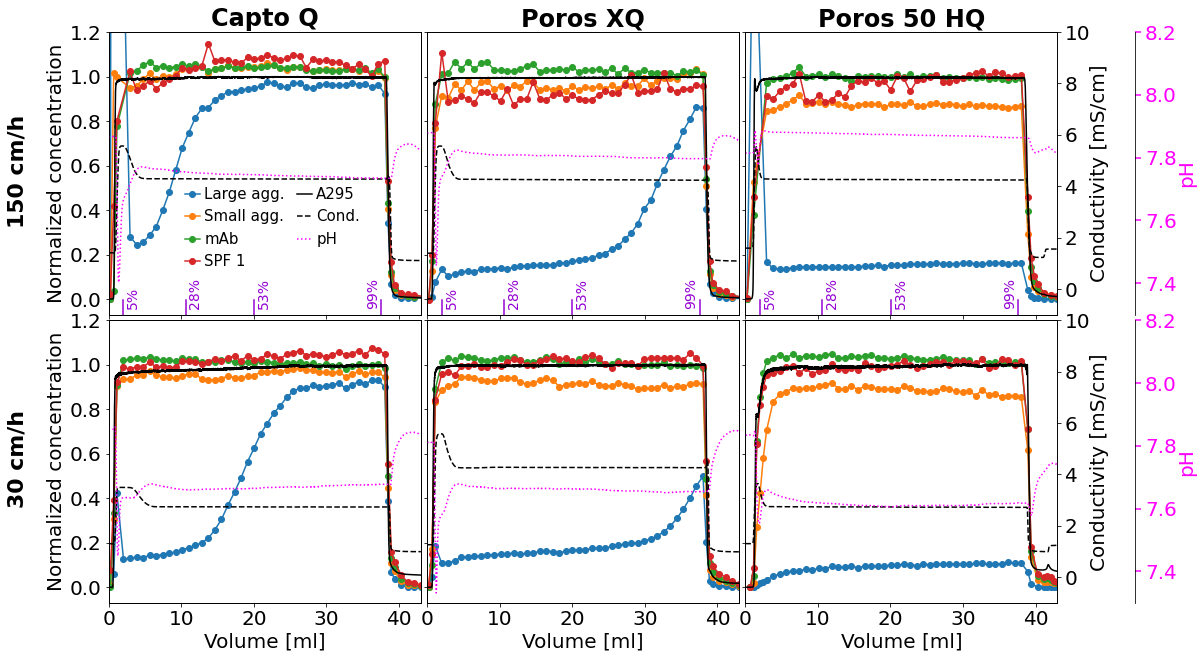

In [51]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.set_size_inches(17, 10.5, forward=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02)

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_150, df_norm_c_150, fig=fig, ax=ax[0, 0], show_twinx=False)
ax[0, 0].set_xlim(0, 43)
ax[0, 0].set_ylim(-0.07, 1.2)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_c_30, df_norm_c_30, fig=fig, ax=ax[1, 0], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_150, df_norm_x_150, fig=fig, ax=ax[0, 1], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_x_30, df_norm_x_30, norm_vol=35, fig=fig, ax=ax[1, 1], show_twinx=False)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)
ax2.set_yticks([])
ax3.set_yticks([])

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_150, df_norm_h_150, fig=fig, ax=ax[0, 2], show_twinx=True, ax3_position=1.25)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)

fig, ax1, ax2, ax3, lns, labs = hplc.with_sec(df_h_30, df_norm_h_30, norm_vol=35, fig=fig, ax=ax[1, 2], show_twinx=True, ax3_position=1.25)
ax2.set_ylim(-1, 10)
ax3.set_ylim(7.3, 8.2)

t = ax[0, 0].set_title('Capto Q', weight='bold')
t = ax[0, 1].set_title('Poros XQ', weight='bold')
t = ax[0, 2].set_title('Poros 50 HQ', weight='bold')
xlabel = ax[1, 0].set_xlabel('Volume [ml]')
xlabel = ax[1, 1].set_xlabel('Volume [ml]')
xlabel = ax[1, 2].set_xlabel('Volume [ml]')

ylabel = ax[0, 0].set_ylabel('Normalized concentration')
ylabel = ax[1, 0].set_ylabel('Normalized concentration')
t = ax[0, 0].annotate('150 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)
t = ax[1, 0].annotate('30 cm/h', xytext=(-14, 1.15/2), xy=(0, 0), rotation=90, weight='bold', va='center', fontsize=22)

plot_mids = list(volume_midpoints[:3])
plot_mids.append(volume_midpoints[-1])
plot_frac_names = ['5%', '28%', '53%', '99%']

for i in range(3):
    for j, (v, frac) in enumerate(zip(plot_mids, plot_frac_names)):
        ax[0, i].axvline(v, ymin=0, ymax=0.05, color='darkviolet')
        if j == 3:
            plt.text(v-2.1, 0.03, frac, rotation=90, color='darkviolet', size=14, transform=ax[0, i].get_xaxis_transform())
        else:
            plt.text(v+0.4, 0.03, frac, rotation=90, color='darkviolet', size=14, transform=ax[0, i].get_xaxis_transform())
        
legend = ax[0, 0].legend(lns, labs, frameon=False, handlelength=1, ncol=2, fontsize=15, columnspacing=0.8, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.2, 0., 0.5, 0.5))

plt.savefig(f'./images/9_all_FT_profiles_with_proteomics_samples.png', dpi=300, bbox_inches='tight')
plt.savefig(f'./images/9_all_FT_profiles_with_proteomics_samples.pdf', bbox_inches='tight')

In [44]:
df_prot

,resin,frac,large_percent,small_percent,total_hmw_percent,percentage_loading
0,cq,1A05,NaN,NaN,NaN,5.352983
1,cq,1B12,1.130801,1.650129,2.780930,27.954736
2,cq,1D09,1.500989,1.659581,3.160571,52.936258
3,cq,1F05,1.545630,1.671260,3.216890,76.727086
4,cq,1G12,1.515527,1.632814,3.148340,99.329623
5,hq,1A05,NaN,NaN,NaN,5.352983
6,hq,1B12,0.239275,1.481278,1.720553,27.954736
7,hq,1D09,0.247970,1.441683,1.689653,52.936258
8,hq,1F05,0.258631,1.448054,1.706685,76.727086
9,hq,1G12,0.267364,1.456616,1.723980,99.329623
